In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd



In [3]:

def first_order_control_system(t, K, tau):
    """
    First-order control system function.
    
    Parameters:
    - K: Gain of the system
    - tau: Time constant of the system
    - t: Time vector
    
    Returns:
    - y: Output of the control system
    """
    y = K * (1 - np.exp(-t/tau))
    return y


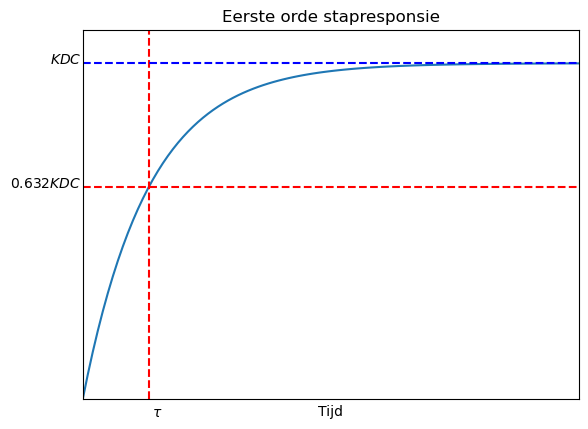

In [4]:

# Generate time vector
t = np.linspace(0, 15, 100)

# Set system parameters
K = 1
tau = 2

# Compute system response
y = first_order_control_system(t, K, tau)

# Plot system response
plt.plot(t, y)
plt.xlabel('Tijd')
plt.ylabel('')

# Draw a line at tau and K
plt.axvline(x=tau, linestyle='--', color='r')
plt.axhline(y=K*0.632, linestyle='--', color='r')
plt.axhline(y=K, linestyle='--', color='b')

# remove x and y ticks
plt.xticks([])
plt.yticks([])

# Set axis limits
plt.ylim(0, 1.1*K)
plt.xlim(0, 15)


# add ticklabels
plt.text(tau+0.1, -0.05, '$\\tau$')
plt.text(-2.2, K*0.632, '$0.632KDC$')
plt.text(-1, K, '$KDC$')

plt.title('Eerste orde stapresponsie')
plt.grid(True)
plt.show()



In [5]:
import pandas as pd

dataframes = []

pwmlist = range(75, 275, 25)

paths = ["Linksom roterend","Rechtsom roterend (rads)"]

for path in paths:
    for value in pwmlist:  
        #Laad csv bestand in als dataframe  
        df = pd.read_csv(f"{path}/pwm_{value}.csv", sep=";")
        
        #zet linksom roterend om naar radialen/s
        if path == "Linksom roterend":
            df["Meting"] = df["Meting"] * 2 * np.pi / 60
            
        #Voor bewerkingen uitvoeren
        df["Meting"] = df["Meting"] / value
        df["Time"] = df["Time"] / 1000
        
        #Toevoegen aan lijst van dataframes
        dataframes.append(df)
    

dataframes[0].head()


,Time,Meting
0,0.000,0.000000
1,0.010,0.000000
2,0.020,0.093089
3,0.030,0.093089
4,0.041,0.093089


K = 0.35176465247818595, tau = 0.1690141329910009
K = 0.32152283461770786, tau = 0.13378534587799207
K = 0.28323432410149146, tau = 0.11262240229411678
K = 0.2434866499531893, tau = 0.06776477232711674
K = 0.21374818164402842, tau = 0.05471066643744678
K = 0.19192555226735267, tau = 0.04154999389648499
K = 0.18240429132073457, tau = 0.03405986138857943
K = 0.1748983223493236, tau = 0.02512989886714237


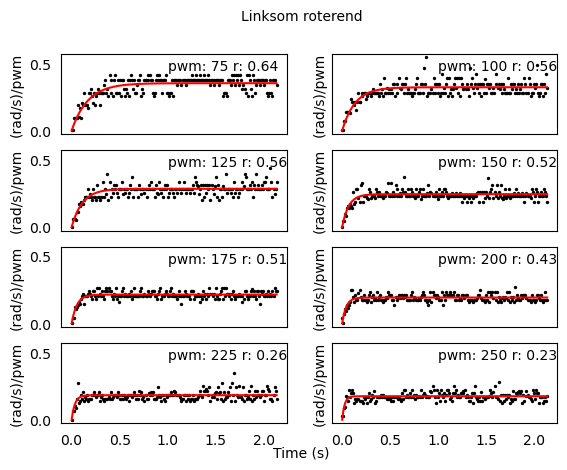

K = 0.3517332026322845, tau = 0.18163184303595897
K = 0.30797770242835437, tau = 0.11567910273634052
K = 0.26489805006464406, tau = 0.09177820763502761
K = 0.22911492409803785, tau = 0.06621114919562315
K = 0.20867026035649575, tau = 0.060694956541686496
K = 0.19329040112648882, tau = 0.06092746224566464
K = 0.17899826974404937, tau = 0.047234764776458306
K = 0.15559785601717757, tau = 0.03787805771046485


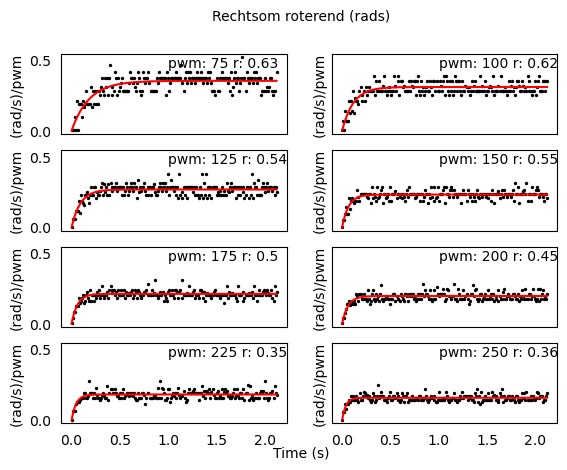

In [6]:
for path in paths:
    params_list = []

    #Create subplots
    fig, plots = plt.subplots(4, 2, sharex=True, sharey=True)
    
    #Get the right dataframes to plot
    if path == "Linksom roterend":
        plot_dfs = dataframes[:8]
    else:
        plot_dfs = dataframes[8:]
    
    #Plot data
    for i, df in enumerate(plot_dfs):
        #Seperate data to plot values
        x_data = df["Time"].values
        y_data = df["Meting"].values
        
        #Create regression lines
        params, covariance = curve_fit(first_order_control_system, x_data, y_data)

        print(f"K = {params[0]}, tau = {params[1]}")
        
        #Get regression plot values
        x_regression = np.linspace(min(x_data), max(x_data), 200)
        y_regression = first_order_control_system(x_regression, *params)
            
        #calculate r-squared
        residuals = y_data - y_regression
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data-np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot)
        r_squared = round(r_squared, 2)
        
        #Plot data and regression
        plots[i // 2, i % 2].scatter(x_data, y_data, label='Data points', marker='o', color='black', s=2)
        
        plots[i // 2, i % 2].plot(x_regression, y_regression, color='red', label='First Order Response')
        
        plots[i // 2, i % 2].set_ylabel('(rad/s)/pwm')
        
        plots[i // 2, i % 2].text(1, 0.45, f'pwm: {pwmlist[i]} r: {r_squared}', fontsize=10)
        
        # Remove tick marks
        plots[i // 2, i % 2].tick_params(bottom=False, left=False)
        
        # Add the params to the list
        params_list.append({'pwm': pwmlist[i], 'kdc': params[0], 'tau': params[1]})

    #Show time axis and dataset name
    fig.text(0.5, 0.04, 'Time (s)', ha='center')
    fig.text(0.5, 0.95, path, ha='center')

    # Create a DataFrame with the params
    params_df = pd.DataFrame(params_list)

    params_df.head()

    # Save the DataFrame to a CSV file
    params_df.to_csv(f'params_{path}.csv', index=False)

    plt.savefig(f"{path}.png")
    plt.show()


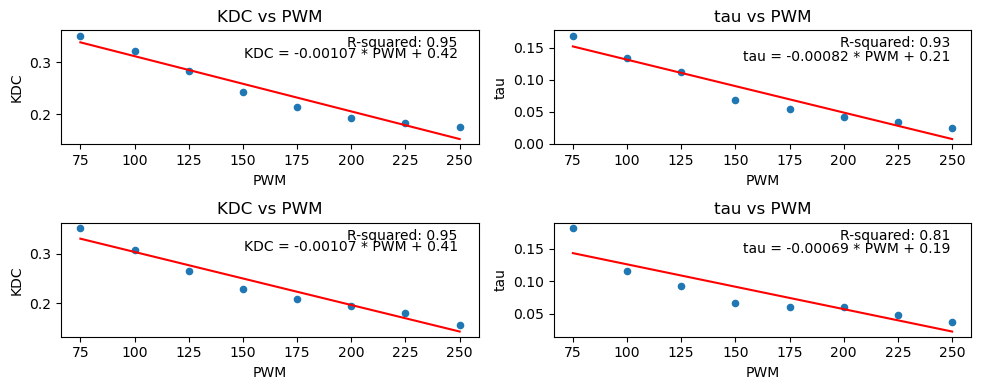

In [7]:
from scipy.stats import linregress

df_links = pd.read_csv(f"params_Linksom roterend.csv")
df_rechts = pd.read_csv(f"params_Rechtsom roterend (rads).csv")
df_pwms = [df_links,df_rechts]

fig, plots = plt.subplots(2, 2, figsize=(10, 4))

for i in range(2):
    (ax1, ax2) = plots[i]
    # Plot KDC vs PWM
    df_pwm = df_pwms[i]
    df_pwm.plot(x='pwm', y='kdc', kind='scatter', ax=ax1)
    ax1.set_xlabel('PWM')
    ax1.set_ylabel('KDC')
    ax1.set_title('KDC vs PWM')

    # Perform linear regression for KDC vs PWM
    slope_kdc, intercept_kdc, r_value_kdc, p_value_kdc, std_err_kdc = linregress(df_pwm['pwm'], df_pwm['kdc'])
    regression_line_kdc = slope_kdc * df_pwm['pwm'] + intercept_kdc
    ax1.plot(df_pwm['pwm'], regression_line_kdc, color='red')

    # Add R-squared value to the plot
    ax1.text(0.95, 0.95, f'R-squared: {r_value_kdc**2:.2f}', transform=ax1.transAxes, ha='right', va='top')

    # Add regression formula to the plot
    ax1.text(0.95, 0.85, f'KDC = {slope_kdc:.5f} * PWM + {intercept_kdc:.2f}', transform=ax1.transAxes, ha='right', va='top')

    # Plot tau vs PWM
    df_pwm.plot(x='pwm', y='tau', kind='scatter', ax=ax2)
    ax2.set_xlabel('PWM')
    ax2.set_ylabel('tau')
    ax2.set_title('tau vs PWM')

    # Perform linear regression for tau vs PWM
    slope_tau, intercept_tau, r_value_tau, p_value_tau, std_err_tau = linregress(df_pwm['pwm'], df_pwm['tau'])
    regression_line_tau = slope_tau * df_pwm['pwm'] + intercept_tau
    ax2.plot(df_pwm['pwm'], regression_line_tau, color='red')

    # Add R-squared value to the plot
    ax2.text(0.95, 0.95, f'R-squared: {r_value_tau**2:.2f}', transform=ax2.transAxes, ha='right', va='top')

    # Add regression formula to the plot
    ax2.text(0.95, 0.83, f'tau = {slope_tau:.5f} * PWM + {intercept_tau:.2f}', transform=ax2.transAxes, ha='right', va='top')
    

    
plt.tight_layout()

plt.savefig("Linear regression (tau, KDC).png")
plt.show()



Text(0.95, 0.83, 'tau = -0.00076 * PWM + 0.20')

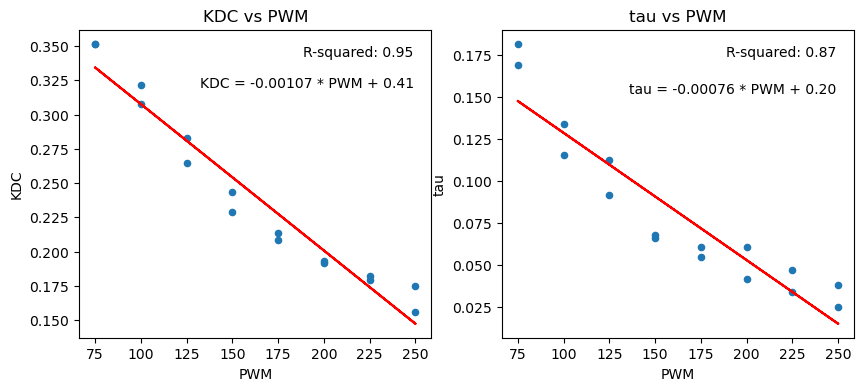

In [8]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

# Plot KDC vs PWM
df_pwm = pd.concat(df_pwms)
df_pwm.plot(x='pwm', y='kdc', kind='scatter', ax=ax1)
ax1.set_xlabel('PWM')
ax1.set_ylabel('KDC')
ax1.set_title('KDC vs PWM')

# Perform linear regression for KDC vs PWM
slope_kdc, intercept_kdc, r_value_kdc, p_value_kdc, std_err_kdc = linregress(df_pwm['pwm'], df_pwm['kdc'])
regression_line_kdc = slope_kdc * df_pwm['pwm'] + intercept_kdc
ax1.plot(df_pwm['pwm'], regression_line_kdc, color='red')

# Add R-squared value to the plot
ax1.text(0.95, 0.95, f'R-squared: {r_value_kdc**2:.2f}', transform=ax1.transAxes, ha='right', va='top')

# Add regression formula to the plot
ax1.text(0.95, 0.85, f'KDC = {slope_kdc:.5f} * PWM + {intercept_kdc:.2f}', transform=ax1.transAxes, ha='right', va='top')

# Plot tau vs PWM
df_pwm.plot(x='pwm', y='tau', kind='scatter', ax=ax2)
ax2.set_xlabel('PWM')
ax2.set_ylabel('tau')
ax2.set_title('tau vs PWM')

# Perform linear regression for tau vs PWM
slope_tau, intercept_tau, r_value_tau, p_value_tau, std_err_tau = linregress(df_pwm['pwm'], df_pwm['tau'])
regression_line_tau = slope_tau * df_pwm['pwm'] + intercept_tau
ax2.plot(df_pwm['pwm'], regression_line_tau, color='red')

# Add R-squared value to the plot
ax2.text(0.95, 0.95, f'R-squared: {r_value_tau**2:.2f}', transform=ax2.transAxes, ha='right',   va='top')

# Add regression formula to the plot
ax2.text(0.95, 0.83, f'tau = {slope_tau:.5f} * PWM + {intercept_tau:.2f}', transform=ax2.transAxes, ha='right', va='top')